# このファイルについて
## 推算すること
### フェーズ1
- 軌道投入に投入するのに必要な燃料
 - 変数：軌道高度

### フェーズ2
- 自然落下する高度
- 摂動

### フェーズ3
- 帰還に必要な燃料
 - アポジのデルタv
- 空力加熱と空力荷重
 - アブレータ設計

擾乱に対する位置制御のために必要な燃料を推算します。

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

g = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 200 #大気圏高度[km]
M_earth = 5.9724*10**24

#機体によるので、あとで
A = 1. #ハヤブサよりちょい大きめ[kg]
Rn = 0.6 #てきとー

#なんかを参照
Cd = 1.6
Cl = 0.0
DT = 0.1#刻み

In [3]:
alpha = 28.58
alpha = np.deg2rad(alpha)
delta_moon = 102.67*np.cos(alpha)*np.sin(alpha)
print(delta_moon)
gamma = 23.44
gamma = np.deg2rad(alpha)
delta_sun = 40.17*np.cos(gamma)*np.sin(alpha)
print(delta_sun)

43.13106201760243
19.216011456044555


In [4]:
def dominant_eq(D,L,gamma,v,r, M):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-g*np.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-g*np.cos(gamma_rad)/v*10**(-3)+v*np.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

def get_precise_density(z):
    matrix = np.array([[0.000000,-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
                       [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
                       [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
                       [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
                       [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
                       [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
                       [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
                       [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
                       [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],                    
                       [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]])
    Zs = np.array([z**4,z**3,z**2,z**1,1])
    if z>750:
        i = 9
        rho = np.exp(Zs@matrix[i])
    elif z>500:
        i = 8
        rho = np.exp(Zs@matrix[i])    
    elif z>300:
        i = 7
        rho = np.exp(Zs@matrix[i])    
    elif z>200:
        i = 6
        rho = np.exp(Zs@matrix[i])   
    elif z>150:
        i = 5
        rho = np.exp(Zs@matrix[i])    
    elif z>120:
        i = 4
        rho = np.exp(Zs@matrix[i])        
    elif z>110:
        i = 3
        rho = np.exp(Zs@matrix[i])    
    elif z>100:
        i = 2
        rho = np.exp(Zs@matrix[i])        
    elif z>91:
        i = 1
        rho = np.exp(Zs@matrix[i])        
    elif z>86:
        i = 0
        rho = np.exp(Zs@matrix[i])
    else:
        rho = RHO_0*np.exp(-z/SCALE_HEIGHT)
    
    return rho

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma, M):
    rho = get_precise_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r, M)
    return np.array([dot_r, dot_v, dot_gamma])

def get_heating_rate(density, v, Rn=Rn):
    """対流加熱と輻射過熱を考える
    Arg:
    density[kg/m^3] 大気密度
    v[km/s] 物体の速度
    Rn[m] ノーズ半径
    
    Return:
    q_conv[MW/m^2] 対流加熱率
    q_rad[MW/m^2] 輻射加熱率
    """
    v *= 10**3
    q_conv = 1.35*10**(-8)*np.sqrt(density/Rn)*v**3.04*10 #[kW/m^2]
    q_conv *= 10**(-3) #[MW/m^2]
    
    if Rn <= 1:
        a = 1.072*10**6*v**(-1.88)*density**(-0.325)
    elif 1< Rn <=2:
        a = min([0.6, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    else:
        a = min([0.5, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    
    f_v = 1.5 #後で直す
    q_rad = 4.736*10**2*Rn**a*density**1.22*f_v
    return q_conv, q_rad
    
def re_entry(v_reEntry,gamma_reEntry, M):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    rho = get_precise_density(h)
    q_conv, q_rad = get_heating_rate(rho, v)
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    q_conv_lst, q_rad_lst = [q_conv], [q_rad]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma,M)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = get_heating_rate(get_precise_density(h), v)
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        q_conv_lst.append(heating_rate[0])
        q_rad_lst.append(heating_rate[1])
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print(h_lst[-1])

    else:
        #print("カプセル帰還")
        pass
    return t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst

In [5]:
class Satellite:
    def __init__(self, dry_mass, mass_capsule, orbital_height, is_capsule=True):
        """衛星のパラメータと軌道設計すれば、全部吐くやつ
        Arg:
            dry_mass[kg] 衛星全部のdry質量
            mass_capsule[kg] カプセルの重量(=dry_mass)
            orbital_height[km] 軌道半径(円軌道)
        Attribute:
        """
        self.dry_mass = dry_mass #dry重量(カプセル含む)
        self.mass_capsule = mass_capsule #カプセル重量(dry重量 - 箱
        
        self.orbital_hegiht = orbital_height #周回軌道高度@phase2
        self.semi_major_axis = orbital_height+R_earth #周回軌道半径@phase2
        self.v_tgt_apo = np.sqrt(MU/self.semi_major_axis) #周回速度@phase2
        self.mass_ab = None
        
    def get_prop_phase1(self, prop_phase3, height_leo=250., Isp=220.):
        """phase1での燃料推算
        Arg:
            prop_phase3[kg] phase3での燃料質量
            hegiht_leo[km] LEO軌道の高度(ここまでは相乗り前提) default:200
            Isp[s] 比推力 default:220
        Return:
            prop_phase1[kg] phase1での必要燃料
        """
        mass_f = self.dry_mass + prop_phase3 + self.mass_ab
        r_leo = height_leo + R_earth
        v_trans_apo = np.sqrt(2.*MU*(1./self.semi_major_axis - 1./(self.semi_major_axis+r_leo)))
        delta_v = self.v_tgt_apo - v_trans_apo
        mass_prop = mass_f*(np.exp(delta_v*10**3/G/Isp)-1)
        return mass_prop
    
    def decision_v_return_apo(self, atmosphere_height=200.):
        """大気に入るためのアポジの最大速度推算
            要するにこれより小さければ戻ってこれる
        Arg:
            atmosphere_height[km] 大気高度 default 200
        Return:
            max_v_apo[km/s] 最大速度
        """
        r_p = atmosphere_height + R_earth
        max_v_apo = np.sqrt(2*MU*(1./self.semi_major_axis-1./(self.semi_major_axis+r_p)))
        return max_v_apo
    
    def get_prop_phase3(self, v_trans_apo, Isp=220., atmosphere_height=200.):
        """phase3での燃料推算
        Arg:
            v_trans_apo[km/s] phase3でのアポジの速度
            Isp[s] 燃料の比推力 default:220.
            atmosphere_height[km] 大気の高度 default:200.
        """
        assert self.decision_v_return_apo(atmosphere_height=atmosphere_height) > v_trans_apo,\
            "帰らない"
        delta_v = self.v_tgt_apo - v_trans_apo
        mass_prop = (self.dry_mass++ self.mass_ab)*(np.exp(delta_v*10**3/G/Isp)-1)
        return mass_prop
    
    def get_tank_parameter(self, mass_prop, density_prop, rate=0.1):
        """タンク設計
        Arg:
            mass_prop[kg] 燃料(酸化剤)重量
            density_prop[kg/m^3] 燃料(酸化剤)の密度
            rate 推進剤重量に対するタンク重量の割合 default:0.1
            
        Return:
            mass_tank[kg] タンク重量
            d_tank[mm] タンクが球形と仮定したときのタンクの直径
        """
        mass_tank = rate*mass_prop
        volume_tank = mass_prop/density_prop
        r_tank = (3*volume_tank/4/PI)**(1/3) #[m]
        d_tank = np.ceil(2*r_tank*10**3) #[mm]
        return mass_tank, d_tank
        
        
    def re_entry_simu(self, v_trans_apo, atmosphere_height=200., plot=False):
        """熱荷重を求める
        Arg:
            v_trans_apo[km/s] 帰還時のアポジの速度
            atmosphere_height[km] 大気高度 default:200
            plot(bool) プロットするかどうか default:False
        Return:
            heat_load[MJ/m^2] 総熱荷重
        """
        assert self.decision_v_return_apo(atmosphere_height=atmosphere_height) > v_trans_apo,\
            "帰らない"
        r_e = atmosphere_height + R_earth
        v_entry = np.sqrt(v_trans_apo**2 + 2*MU*(1/r_e-1/self.semi_major_axis))
        fpa_entry = np.rad2deg(-np.arccos(v_trans_apo*self.semi_major_axis/v_entry/r_e))
        print(fpa_entry)
        t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst \
            = re_entry(v_entry, fpa_entry, M=self.mass_capsule)
        heat_load = 0
        for i in range(len(t_lst)-1):
            heat_flux = q_conv_lst[i] + q_rad_lst[i]
            heat_load += heat_flux*DT
        
        if plot is True:
            plt.plot(v_lst, h_lst)
            plt.show()
            plt.plot(t_lst, q_conv_lst)
            plt.show()
            
        return heat_load
    
    def get_ablator_mass(self, heat_load):
        """アブレーターの重さをもとメルル
        Arg:
            heat_load[MJ/m^2] 総熱荷重
        Return:
            mass_ablator[kg]
        """
        heat_load = heat_load*10**2 #[J/cm^2]
        mass_fraction = 0.091*heat_load**0.51
        mass_fraction /= 100.
        mass_ablator = mass_fraction * self.mass_capsule
        self.mass_ab = mass_ablator
        return mass_ablator
    
    def get_ablator_thickness(self, mass_ablator, area_capsule, density_ablator=1000.):
        """アブレータの厚さを求める
        Arg:
            mass_ablator[kg] アブレータ質量
            area_capsure[m^2] アブレータの表面積=カプセルの前方
            density_ablator[kg/m^3] アブレータ default:1000（炭化アブレータ）
        
        Return:
            thickness_ablator[mm] アブレータの厚さ
        """
        thickness_ablator = mass_ablator/area_capsule/density_ablator#[m]
        thickness_ablator *= 1000 #[mm]
        return thickness_ablator

インスタンス作成

In [6]:
a = Satellite(800., 800., 25000.)

再突入計算

デルタV計算

In [7]:
v_trans_apo_max = a.decision_v_return_apo()
delta_v_min = a.v_tgt_apo-v_trans_apo_max
print("delta_vの最小値:{}[km/s]".format(delta_v_min))

delta_vの最小値:1.4658013214995527[km/s]


In [8]:
v_trans_apo = 2.
delta_v = a.v_tgt_apo - v_trans_apo
print("deltaV:{0}[km/s]".format(delta_v))

deltaV:1.5641503650365927[km/s]


-17.2435447577513


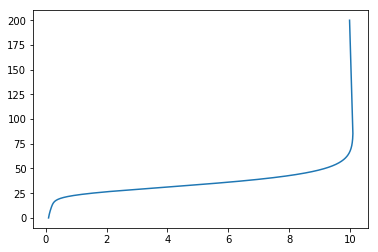

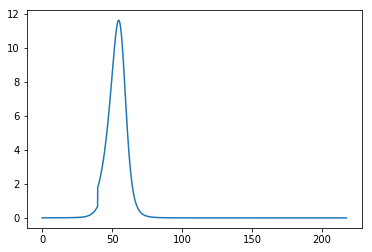

熱荷重:302.0104970950963[MJ/m^2]
アブレータ質量:140.26283698289123[kg]
アブレータ厚さ:46.754278994297074[mm]


In [9]:
heat_load = a.re_entry_simu(v_trans_apo, plot=True)
mass_ablator = a.get_ablator_mass(heat_load)
thickness_ablator = a.get_ablator_thickness(mass_ablator, 3.)
print("熱荷重:{}[MJ/m^2]".format(heat_load))
print("アブレータ質量:{}[kg]".format(mass_ablator))
print("アブレータ厚さ:{}[mm]".format(thickness_ablator))

In [10]:
#燃料
##phase3:Isp 295[s]カプセルのやつ 
            # 1700[kg/m^3]
##phase1:Isp 320[s]4酸化２窒素-ヒドラジン
            # Oxi:四酸化二窒素:1443[kg/m^3]
            # fuel:ヒドラジン:1013[kg/m^3]
            # O/F = 2 
        
prop_phase3 = a.get_prop_phase3(v_trans_apo, Isp=295)
prop_phase1 = a.get_prop_phase1(prop_phase3, Isp=320)
print("phase1の燃料:{}[kg]".format(prop_phase1))
print("phase3の燃料:{}[kg]".format(prop_phase3))

mf = prop_phase1/3.
mo = 2./3.*prop_phase1
print("phase1の燃料重量:{0}[kg]\nphase1の酸化剤重量:{1}[kg]".format(mf, mo))

#phase1の燃料タンク
mass_tank_phase1_fuel, d_tank_phase1_fuel = a.get_tank_parameter(mf, 1013)
print("phase1の燃料タンクの重量:{0}[kg]\n  タンク径:{1}[mm]".format(mass_tank_phase1_fuel, d_tank_phase1_fuel))

#phase1の酸化剤タンク
mass_tank_phase1_oxi, d_tank_phase1_oxi = a.get_tank_parameter(mo, 1443)
print("phase1の酸化剤タンクの重量:{0}[kg]\n  タンク径:{1}[mm]".format(mass_tank_phase1_oxi, d_tank_phase1_oxi))

#phase3の推進剤タンク
mass_tank_phase3_prop, d_tank_phase3_prop = a.get_tank_parameter(prop_phase3, 1700)
print("phase3の推進剤タンクの重量:{0}[kg]\nphase3のタンク径:{1}[mm]".format(mass_tank_phase3_prop, d_tank_phase3_prop))


NameError: name 'G' is not defined

In [ ]:
v_trans_apo_max = np.floor(a.decision_v_return_apo()*10.)/10.
v_trans_apo_lst = np.arange(1.0, v_trans_apo_max, 0.01)
mass_ablator_lst = np.zeros_like(v_trans_apo_lst)
delta_v_phase3_lst = np.zeros_like(v_trans_apo_lst)
heat_load_lst = np.zeros_like(v_trans_apo_lst)
for i in range(len(v_trans_apo_lst)):
    delta_v_phase3_lst[i] = a.v_tgt_apo - v_trans_apo_lst[i]
    heat_load = a.re_entry_simu(v_trans_apo_lst[i])
    heat_load_lst[i] = heat_load
    mass_ablator = a.get_ablator_mass(heat_load)
    mass_ablator_lst[i] = mass_ablator
    

    
plt.plot(delta_v_phase3_lst, mass_ablator_lst)
plt.xlabel("$\Delta v$[km/s]")
plt.ylabel("Ablator$\mathrm{[MJ/m^2]}$重量")
plt.savefig("../output/mass_ablator.png")
plt.show()

In [ ]:
def get_DDr(r,t):
    CR = 1
    Phi = 1358
    c = 299792458
    A = 4
    m = 1300
    G_grav = 6.67e-11
    M_earth = 5.97e24
    
    year = 3600*24*365
    e = np.array([np.cos(2*np.pi*t/year),
                  np.cos(2*np.pi*t/year)])
    
    r = np.array(r)
    Fs = -CR*Phi*A/c/m*e
    Fe = -G_grav*M_earth*r/(np.linalg.norm(r)**3)
    DDr = Fs + Fe
    return DDr.tolist()

def get_dotx(x,t,dt):
    DDr = get_DDr([x[2],x[3]],t)
    Dr = [x[0] + DDr[0]*dt, x[1] + DDr[1]*dt]
    return [DDr[0],DDr[1],Dr[0],Dr[1]]

def solve_eq(x_init,dotx,dt,nsteps,rungekutta=False):
    t = [dt*i for i in range(nsteps)]
    x = [x_init]
    x_temp = x_init
    if rungekutta:
        for i in range(nsteps):
            k1 = np.array(dotx(x_temp,t[i],dt))
            k2 = np.array(dotx((np.array(x_temp) + k1/2*dt).tolist(),t[i],dt))
            k3 = np.array(dotx((np.array(x_temp) + k2/2*dt).tolist(),t[i],dt))
            k4 = np.array(dotx((np.array(x_temp) + k3*dt).tolist(),t[i],dt))
            x_temp = (np.array(x_temp) + (k1+2*k2+2*k3+k4)*dt).tolist()
            x.append(x_temp)
    else:
        for i in range(nsteps):
            k1 = np.array(dotx(x_temp,t[i],dt))
            x_temp = (np.array(x_temp) + (k1)*dt).tolist()
            x.append(x_temp)        
    return x

In [ ]:
dt = 1
nsteps = 100000
G_grav = 6.67e-11
M_earth = 5.97e24

x_init = [0,np.sqrt(G_grav*M_earth/31371000),31371000,0]
x = solve_eq(x_init,get_dotx,dt,nsteps)

In [ ]:
x = np.array(x)
plt.plot(x[:,2],x[:,3])

## 軌道投入推進重量の概算
半径6600kmから高度1200kmまでのホーマン軌道に入れた後、
高度1200kmにおける減速量を計算する。
\begin{align*}
    v_{p@before} = \sqrt{2\mu\left(\frac{1}{r_p}-\frac{1}{r_a+r_p}\right)} \\
    v_{p@after} = \sqrt{\frac{\mu}{r_p}}
\end{align*}

In [ ]:
def dominant_eq(D,L,gamma,v,r, M=M_capcell):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-G*np.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-G*np.cos(gamma_rad)/v*10**(-3)+v*np.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

def get_precise_density(z):
    matrix = np.array([[0.000000,-3.322622E-6,9.111460E-4,-0.2609971,5.944694],
                       [0.000000,2.873405E-5,-0.008492037,0.6541179,-23.62010],
                       [-1.240774E-5,0.005162063,-0.8048342,55.55996,-1443.338],
                       [0.00000,-8.854164E-05,0.03373254,-4.390837,176.5294],
                       [3.661771E-7,-2.154344E-4,0.04809214,-4.884744,172.3597],
                       [1.906032E-8,-1.527799E-5,0.004724294,-0.6992340,20.50921],
                       [1.199282E-9,-1.451051E-6,6.910474E-4,-0.1736220,-5.321644],
                       [1.140564E-10,-2.130756E-7,1.570762E-4,-0.07029296,-12.89844],
                       [8.105631E-12,-2.358417E-9,-2.635110E-6,-0.01562608,-20.02246],                    
                       [-3.701195E-12,-8.608611E-9,5.118829E-5,-0.06600998,-6.137674]])
    Zs = np.array([z**4,z**3,z**2,z**1,1])
    if z>750:
        i = 9
        rho = np.exp(Zs@matrix[i])
    elif z>500:
        i = 8
        rho = np.exp(Zs@matrix[i])    
    elif z>300:
        i = 7
        rho = np.exp(Zs@matrix[i])    
    elif z>200:
        i = 6
        rho = np.exp(Zs@matrix[i])   
    elif z>150:
        i = 5
        rho = np.exp(Zs@matrix[i])    
    elif z>120:
        i = 4
        rho = np.exp(Zs@matrix[i])        
    elif z>110:
        i = 3
        rho = np.exp(Zs@matrix[i])    
    elif z>100:
        i = 2
        rho = np.exp(Zs@matrix[i])        
    elif z>91:
        i = 1
        rho = np.exp(Zs@matrix[i])        
    elif z>86:
        i = 0
        rho = np.exp(Zs@matrix[i])
    else:
        rho = RHO_0*np.exp(-z/SCALE_HEIGHT)
    
    return rho

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma, M):
    rho = get_precise_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r, M)
    return np.array([dot_r, dot_v, dot_gamma])

def get_heating_rate(density, v, Rn=Rn):
    """対流加熱と輻射過熱を考える
    Arg:
    density[kg/m^3] 大気密度
    v[km/s] 物体の速度
    Rn[m] ノーズ半径
    
    Return:
    q_conv[MW/m^2] 対流加熱率
    q_rad[MW/m^2] 輻射加熱率
    """
    v *= 10**3
    q_conv = 1.35*10**(-8)*np.sqrt(density/Rn)*v**3.04*10 #[kW/m^2]
    q_conv *= 10**(-3) #[MW/m^2]
    
    if Rn <= 1:
        a = 1.072*10**6*v**(-1.88)*density**(-0.325)
    elif 1< Rn <=2:
        a = min([0.6, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    else:
        a = min([0.5, 1.072*10**6*v**(-1.88)*density**(-0.325)])
    
    f_v = 0.1#後で直す
    q_rad = 4.736*10**2*Rn**a*density**1.22*f_v
    return q_conv, q_rad
    
def re_entry(v_reEntry,gamma_reEntry, M):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    rho = get_precise_density(h)
    q_conv, q_rad = get_heating_rate(rho, v)
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    q_conv_lst, q_rad_lst = [q_conv], [q_rad]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma,M)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2, M)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2, M)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma, M)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        heating_rate = get_heating_rate(get_precise_density(h), v)
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        q_conv_lst.append(heating_rate[0])
        q_rad_lst.append(heating_rate[1])
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print(h_lst[-1])

    else:
        #print("カプセル帰還")
        pass
    return t_lst, h_lst, v_lst, gamma_lst, q_conv_lst, q_rad_lst

# 再突入のΔｖ概算
## to do
大気とか概算なので、ちゃんと後でどっかのデータ引用した方がよい

おそらく高度20㎞とかでパラシュート展開するのかな
## 大気圏内の支配方程式
\begin{align*}
\frac{dv}{dt} = \ddot{x} =-\frac{D}{m} - g\sin\gamma \\
v\frac{d\gamma}{dt} = \frac{L}{m} - g\cos\gamma + \frac{v^2}{r}\cos{\gamma}
\end{align*} 

In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm

font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)

#fm.findSystemFonts()

In [ ]:
class Dicision_Entry():
    def __init__(self):
        pass
    def solve(self):
        pass

In [ ]:
def get_P_after_t(P_0,t,A,V):
    return P_0*np.exp(-(A/V)*t*180)
def year_to_sec(year):
    return 3600*24*365*year

In [ ]:
z = 800
P_f = np.exp(2.8132e-11*z**4 -1.12e-7*z**3+1.6955e-4*z**2-0.11889*z+14.567)
P_i = 1e5
V = 1.2e-4
A = 5e-15
T_i = 220
t = 0.086*V/A*np.log(P_i/P_f)/np.sqrt(T_i)
t

In [ ]:
t_list = np.arange(0,year_to_sec(20),1e5)
P_list = get_P_after_t(P_i,t_list,A,V)
plt.plot(t_list,P_list)
plt.plot(t_list,np.ones_like(t_list)*1000)

# 必要燃料@帰還時の推算
## 方針
1. 大気圏突入速度を決める←多分、決め打ち
2. そこから逆算して、アポジキック(逆噴射)決定

## 使う方程式
以下
\begin{align*}
\alpha = \frac{rv^2}{\mu}
\end{align*}
とすると、
### 離心率の決定
\begin{align*}
e = \sqrt{(\alpha-2)\alpha\cos^2\gamma+1}
\end{align*}
### 遷移軌道時の軌道長半径の決定
\begin{align*}
r_a = \frac{1+e\cos\theta}{1-e^2}r
\end{align*}
この辺いらんな。。。。一応デバッグ要員として

角運動量一定より、
\begin{align*}
v_{@apo} = \frac{h}{r_{@apo}} = \frac{r_{entry}v_{entry}\cos\gamma_{entry}}{r_{circuit}}
\end{align*}
が燃料噴射直後の速さなので、
\begin{align*}
\Delta v = v_{circuit}-v_{@apo}
\end{align*}
が減速量で、燃料を最終質量$m_f$(カプセル重量から引っ張ってくる)から逆算して
\begin{align*}
m_{prop_{@return}} = m_f\left(e^{\frac{\Delta v}{gI_{sp}}}-1\right)
\end{align*}


In [ ]:
def get_prop(r0, r, v, gamma, mf=300, Isp=220):
    """
    ある点の情報がわかれば、遠地点(仮)での推進剤重量がわかり幸せになれる
    arg:
        r0[km] 周回軌道半径(遠地点(仮))
        ####遠地点
        r[km] ある地点でのr
        v[km/s] ある地点での速さ
        gamma[deg] ある地点での経路角
        
        mf[kg] 最終重量(本体ごと突っ込む)
                default:300kg(はやぶさ参照)
        Isp[s] 燃料のIsp
                default:220(???????????????)
        
    return:
        mp[kg] 必要燃料重量
                
    
    """
    gamma = np.deg2rad(gamma)
    alpha = r*v**2/MU#無次元数の何か
    h = r*v*np.cos(gamma)
    l = h**2/MU
    theta = np.arange(0,2*PI, 0.01)
    #離心率の決定(楕円軌道前提)--間違っている
    eccentricity = np.sqrt((alpha-2)*alpha*(np.cos(gamma))**2+1)
    print("離心率は{}".format(eccentricity))
    r_tgt = l/(1+eccentricity*np.cos(theta))
    r0_lst = [r0 for i in range(len(theta))]
    r_lst = [r for i in range(len(theta))]
    #plt.polar(theta, r_tgt)
    plt.polar(theta, r0_lst)
    plt.polar(theta, r_lst)
    #plt.show()
    #真近点離角
    tan_true_anomaly = alpha*np.sin(gamma)*np.cos(gamma)/(alpha*(np.cos(gamma))**2-1)
    true_anomaly = math.atan(tan_true_anomaly)
    print("真近点離角は{}".format(true_anomaly))
    
    #半長軸の決定
    semi_major_axis = (1+eccentricity*np.cos(true_anomaly))*r/(1-eccentricity**2)
    print("半長軸の長さ{}[km]".format(semi_major_axis))
    
    #燃料噴出"前"の速さ
    print("減速前の速さ{}[km/s]".format(np.sqrt(MU/r0)))
    #燃料噴出"直"後の速さ
    v0 = r*v*np.cos(gamma)/r0
    print("減速後の速さ{}[km/s]".format(v0))
    alpha0 = r0*v0**2/MU
    e0 = alpha0-1
    theta2 = np.arange(0, 2.5, 0.01)
    r_tgt2 = l/(1+e0*np.cos(theta2))
    plt.polar(theta2, r_tgt2)
    plt.show()
    delta_v = np.sqrt(MU/r0) - v0
    print("減速量{}[km/s]".format(delta_v))
    
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print("燃料は{}[kg]".format(mp))
    
    return None

R0 = R_earth +1200
R1 = R_earth + 200
#get_prop(R0, R1, v=v_entry, gamma=gamma_entry)

In [ ]:
## min(ダイレクトを目指す条件下)
Rp = R_earth+200
Ra = R_earth+1200
Vp = np.sqrt(2*MU*(1/Rp-1/(Rp+Ra)))
Va = np.sqrt(2*MU*(1/Ra-1/(Rp+Ra)))
print("定常飛行時:{0}km/s".format(np.sqrt(MU/Ra)))
print("最小燃料の遠地点速度Va:{0}km/s".format(Va))
#print("最小燃料の近地点速度Vp:{0}km/s".format(Vp))

In [ ]:
###### 燃料
def get_m_prop_phase3(v_trans_apo, mf=200, Isp=266):
    delta_v = np.sqrt(MU/Ra) - v_trans_apo
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print(mp)
    return mp

mp_phase3 = get_m_prop_phase3(6.5)

def get_prop_phase1(h_tgt=1200, r_po=R_po, mf=200+mp_phase3, Isp=266):
    """
    h_tgt[km] フェーズ2の周回軌道高度
    h_po[km] POの高度
    mf[kg] ドライ重量(フェーズ３除く)
    Isp[s] Isp
    """
    r_tgt = h_tgt+R_earth
    v_a_before = np.sqrt(2*MU*(1./r_tgt-1./(r_tgt+r_po)))
    v_a_after = np.sqrt(MU/r_tgt)
    delta_v = v_a_after-v_a_before
    mp = mf*(np.exp(delta_v*10**3/G/Isp) -1)
    print(mp)
    return None
get_prop_phase1()

## 逆ホーマンの遠地点速度の決定
上より、
\begin{align*}
v_{trans@apo} \leq 7.00~\rm{[km/s]}  
\end{align*}
この範囲で、さらに絞る。

In [ ]:
#アポジキックの存在可能速度範囲
v_trans_apo_lst = np.arange(0.01, 7.00, 0.1)
#大気圏突入速度と経路角を決定する。
Re = R_earth+200
v_entry_lst = np.zeros_like(v_trans_apo_lst) #大気圏突入速度
fpa_entry_lst = np.zeros_like(v_trans_apo_lst) #経路角
for i in range(len(v_trans_apo_lst)):
    v_entry_lst[i] = np.sqrt(v_trans_apo_lst[i]**2 + 2*MU*(1/Re-1/Ra))
    fpa_entry_lst[i] = np.rad2deg(-np.arccos(v_trans_apo_lst[i]*Ra/v_entry_lst[i]/Re))

"""
fig, ax1 = plt.subplots()
ax1.plot(v_trans_apo_lst, v_entry_lst, color='blue', label='v_entry[km/s]')
ax2 = ax1.twinx()
ax2.plot(v_trans_apo_lst, fpa_entry_lst, color='orange', label='FPA[deg]')
plt.legend()
plt.show()
"""

#その後着陸までの軌道決定。
t_group, h_group, v_group, q_conv_group, q_rad_group, heat_flux_group = [], [], [], [], [], []
for i in range(len(v_trans_apo_lst)):
    t_atm_lst, h_atm_lst, v_atm_lst, gamma_atm_lst, q_conv_lst, q_rad_lst \
        =re_entry(v_entry_lst[i], fpa_entry_lst[i])
    heat_flux_atm_lst = []
    for j in range(len(q_conv_lst)):
        heat_flux_atm_lst.append(q_conv_lst[j]+q_rad_lst[j])
    t_group.append(t_atm_lst)
    h_group.append(h_atm_lst)
    v_group.append(v_atm_lst)
    q_conv_group.append(q_conv_lst)
    q_rad_group.append(q_rad_lst)
    heat_flux_group.append(heat_flux_atm_lst)

In [ ]:
## q_convとq_radを加算
len(heat_flux_group[0])


In [ ]:
### Max Heat flux と Max heat loadの算出
def get_heat(heat_flux_lst, dt=DT):
    """MaxHeatFlux　と　MaxHeatLoadの算出
    Arg:
        heat_flux_lst (list) 1回のheat fluxの変遷,[kW/m^2]
        dt[s] 刻み default=DT
    
    Return:
        max_heat_flux (float) 一回の軌道の最大heatflux [MW/m^2]
        heat_load (float) 一回の軌道のheatload [MJ/m^2]
    """
    max_heat_flux = max(heat_flux_lst)
    heat_load = 0
    for i in range(len(heat_flux_lst)):
        heat_load += heat_flux_lst[i]*dt
    return max_heat_flux, heat_load

phase2_v = np.sqrt(MU/Ra)
delta_v_lst = [] #x軸
max_heat_flux_lst = [] #y軸1
heat_load_lst = [] #y軸2
for i in range(len(v_trans_apo_lst)):
    delta_v = phase2_v - v_trans_apo_lst[i]
    heat_flux_lst = heat_flux_group[i]
    max_heat_flux, heat_load = get_heat(heat_flux_group[i])
    
    delta_v_lst.append(delta_v)
    max_heat_flux_lst.append(max_heat_flux)
    heat_load_lst.append(heat_load)

plt.plot(delta_v_lst, max_heat_flux_lst, label="max heatflux")
plt.xlabel(r"$\Delta$ v[km/s]")
plt.ylabel("max heat flux[MW/m^2]")
plt.legend()
plt.savefig("../output/capsule/max_heat_flux.png")
plt.show()
plt.plot(delta_v_lst, heat_load_lst, label="heat load")
plt.xlabel(r"$\Delta$ v[k/s]")
plt.ylabel("heat load[MJ/m^2]")
plt.legend()
plt.savefig("../output/capsule/heat_load.png")
plt.show()

In [ ]:
N = len(t_group)
print(N)
for i in range(N):
    plt.plot(t_group[i], q_conv_group[i], label=str(v_entry_lst[i].round(3))+"[km/s]")
plt.legend()
plt.savefig('../output/q_conv.png')
plt.show()

for i in range(N):
    plt.plot(t_group[i], q_rad_group[i], label=str(v_entry_lst[i].round(3))+"[km/s]")
plt.legend()
plt.savefig('../output/q_rad.png')
plt.show()

for i in range(N):
    plt.plot(t_group[i], h_group[i])
plt.savefig("../output/height.png")
plt.show()

for i in range(N):
    plt.plot(t_group[i], v_group[i])
plt.savefig("../output/height.png")
plt.show()


In [ ]:
#擾乱の永年項を計算
#計算量多めなので、後で直す
def gravity_perturbation_moon(r, i):
    """
    月の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_moon(float) 近地点引数の変化[deg/day]
    dot_Omega_moon(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_moon = -0.00338*np.cos(i)/n
    dot_omega_moon = 0.00169*(4-5*(np.sin(i))**2)/n
    return dot_Omega_moon, dot_omega_moon

def gravity_perturbation_sun(r, i):
    """
    太陽の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_sun(float) 近地点引数の変化[deg/day]
    dot_Omega_sun(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_sun = -0.00154*np.cos(i)/n
    dot_omega_sun = 0.00077*(4-5*((np.sin(i))**2))/n
    return dot_Omega_sun, dot_omega_sun

print(gravity_perturbation_sun(6700, 28))

In [ ]:
class Orbit:
    """なんか軌道わかるとうまくいくやつ()
    to do
    外乱制御用のΔV
    """
    
    def __init__(self, r_tgt):
        """とりあえず円周回軌道半径だけ。。。"""
        self.r_tgt = r_tgt # radius of orbit
        self.delta_v_peri = None
        self.delta_v_apo = None
        self.delta_v = None
        
        self.reentry_height = 100 #地球の大気圏高度[km]
        self.v_tgt = None
    def get_delta_v_peri(self):
        """近地点でのΔv"""
        r_tgt = self.r_tgt
        v_po = np.sqrt(MU/R_po)
        v_peri_trans = np.sqrt(2*MU*r_tgt/R_po/(R_po+r_tgt))
        self.delta_v_peri = v_peri_trans - v_po

    def get_delta_v_apo(self):
        """遠地点でのΔv"""
        r_tgt = self.r_tgt
        self.v_tgt = np.sqrt(MU/r_tgt)
        v_apo_trans = np.sqrt(2*MU*R_po/r_tgt/(R_po+r_tgt))
        self.delta_v_apo = self.v_tgt-v_apo_trans
    
    def j2(self):
        """
        外乱J2項考えましょうね～～～～～～～～～～
        """
    
    def get_delta_v(self):
        """Δv全部"""
        self.get_delta_v_peri()
        self.get_delta_v_apo()
        self.delta_v = self.delta_v_apo+self.delta_v_peri
        print("Delta V: {0} [km/s]".format(self.delta_v))
        print("V at tgt: {}[km/s]".format(self.v_tgt))

In [ ]:
orb = Orbit(7200.)
orb.get_delta_v()

# 空気抵抗による落下の推算

空気抵抗による高度落下を計算。  
\begin{align*}
\frac{dr}{dt} = -\frac{\rho V C_d A_s r}{m} = -\rho \frac{C_d A_s}{m}\sqrt{GMr}
\end{align*}

In [ ]:
def get_drdt(r,Cd,As,m):
    """ r,drの単位は[km] """
    rho = get_density(r-R_earth)
    return (-rho*Cd*As*np.sqrt(G*M_earth*r*1000)/m) /1000

def solve_air_drag_eq(r0,dt=10**1,nstep=10**5,Cd_sat=2.2,As=20.,m_sat=500.):
    r_rev = [r0]
    for i in range(nstep):
        dr = get_drdt(r_rev[i],Cd_sat,As,m_sat)*dt
        new = r_rev[i] + dr
        if new > 0:
            r_rev.append(new)
        else:
            r_rev.append(R_earth)
    return r_rev[1:]

In [ ]:
dt = 10**4
nstep = 10**4
r_rev = solve_air_drag_eq(380+R_earth,dt=dt,nstep=nstep)

In [ ]:
t = np.arange(0,nstep*dt,dt)/3600/24 # 単位はday
plt.plot(t,r_rev)

In [ ]:
r_rev = solve_air_drag_eq(300+R_earth,dt=dt,nstep=nstep)